In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from abc import ABC, abstractmethod

In [5]:
class Trip:
    """Represents a trip with attributes like city, budget, duration, activity, and logic."""
    # This defines a new class
    def __init__(self, city, budget, duration, activity, logic_expression):
        # Constructor of the class
        self.city = city # variable assignment
        self.budget = float(budget) # variable assignment
        self.duration = int(duration) # variable assignment
        self.activity = activity # variable assignment
        self.logic_expression = logic_expression # variable assignment

    def __str__(self):
        """Returns a string representation of the trip."""
        # This defines a function
        return f"{self.city} | ${self.budget} | {self.duration} days | {self.activity} | Logic: {self.logic_expression}"

class User:
    """Stores user preferences for filtering trips."""
    # This defines a new class
    def __init__(self, max_budget=None, max_duration=None):
        # Constructor of the class
        self.max_budget = max_budget # variable assignment
        self.max_duration = max_duration # variable assignment

class TruthTableEvaluator:
    """Evaluates logical expressions (like p ∧ q) for each trip based on user constraints."""
    # This defines a new class
    def __init__(self, trip, user):
        # Constructor of the class
        self.trip = trip # variable assignment
        self.user = user # variable assignment

    def evaluate_expression(self):
        p = self.trip.budget < self.user.max_budget if self.user.max_budget is not None else True
        q = self.trip.duration < self.user.max_duration if self.user.max_duration is not None else True

        expr = self.trip.logic_expression.replace("¬", "not ").replace("∧", "and").replace("∨", "or")
        expr = expr.replace("p", str(p)).replace("q", str(q))
        expr = expr.replace("→", " or not ").replace("↔", " == ")

        try:
            return eval(expr)
        except Exception as e:
            print(f"Error evaluating expression '{self.trip.logic_expression}': {e}")
            return False

In [6]:
class BasePlanner(ABC):
    # This defines a new class
    def __init__(self, trips):
        # Constructor of the class
        self.trips = trips # variable assignment

    @abstractmethod
    def sort(self, user):
        """Sorts the trips based on either budget or duration, and logic."""
        # This defines a function
        pass

    @abstractmethod
    def print_trips(self):
        """Prints all trips in the planner."""
        # This defines a function
        pass

class Planner(BasePlanner):
    # This defines a new class
    def sort(self, user):
        """Sorts the trips based on either budget or duration, and logic."""
        # This defines a function
        for i in range(1, len(self.trips)):
            key_trip = self.trips[i] # variable assignment
            j = i - 1 # variable assignment
            while j >= 0 and self.trips[j].budget > key_trip.budget: # variable assignment
                self.trips[j + 1] = self.trips[j] # variable assignment
                j -= 1 # variable assignment
            self.trips[j + 1] = key_trip # variable assignment
        self.trips.sort(key=lambda t: not TruthTableEvaluator(t, user).evaluate_expression()) # variable assignment

    def print_trips(self):
        """Prints all trips in the planner."""
        # This defines a function
        for trip in self.trips:
            print(trip) # output to console

In [7]:
class RecursivePlanner(BasePlanner):
    # This defines a new class
    def merge_sort_by_duration(self, trips):
        """Sorts the trips based on either budget or duration, and logic."""
        # This defines a function
        if len(trips) <= 1: # variable assignment
            return trips # return result
        mid = len(trips) // 2 # variable assignment
        left = self.merge_sort_by_duration(trips[:mid]) # variable assignment
        right = self.merge_sort_by_duration(trips[mid:]) # variable assignment
        return self._merge(left, right) # return result

    def _merge(self, left, right):
        # This defines a function
        result = [] # variable assignment
        i = j = 0 # variable assignment
        while i < len(left) and j < len(right):
            if left[i].duration <= right[j].duration: # variable assignment
                result.append(left[i])
                i += 1 # variable assignment
            else:
                result.append(right[j])
                j += 1 # variable assignment
        result.extend(left[i:])
        result.extend(right[j:])
        return result # return result

    def sort(self, user):
        """Sorts the trips based on either budget or duration, and logic."""
        # This defines a function
        self.trips = self.merge_sort_by_duration(self.trips) # variable assignment
        self.trips.sort(key=lambda t: not TruthTableEvaluator(t, user).evaluate_expression()) # variable assignment

    def print_trips(self):
        """Prints all trips in the planner."""
        # This defines a function
        for trip in self.trips:
            print(trip) # output to console

In [13]:
def main_menu(trips, user):
    """Interactive console menu for sorting, searching, saving and analyzing trips."""
        # This defines a function
    planner = Planner(trips.copy()) # variable assignment
    recursive_planner = RecursivePlanner(trips.copy()) # variable assignment
    last_sorted = [] # variable assignment

    while True:
        print("\n=== Travel Planner Menu ===") # output to console
        print("1. Sort by budget + logic (loop)") # output to console
        print("2. Sort by duration + logic (recursion)") # output to console
        print("3. Search trip by city name") # output to console
        print("4. Save last sorted trips to CSV") # output to console
        print("5. Compare performance of sorting algorithms") # output to console
        print("6. Exit") # output to console

        choice = input("Enter your choice (1-6): ").strip() # variable assignment

        if choice == '1':
            planner.sort(user)
            planner.print_trips()
            last_sorted = planner.trips.copy() # variable assignment
        elif choice == '2':
            recursive_planner.sort(user)
            recursive_planner.print_trips()
            last_sorted = recursive_planner.trips.copy() # variable assignment
        elif choice == '3':
            name = input("Enter city name to search: ").strip().lower()
            found = [trip for trip in trips if trip.city.strip().lower() == name]
            if found:
                print("\nFound Trip:") # output to console
                for trip in found:
                    print(trip) # output to console
            else:
                print("No trip found for that city.") # output to console
        elif choice == '4':
            if last_sorted:
                df_out = pd.DataFrame([vars(t) for t in last_sorted]) # variable assignment
                df_out.to_csv("sorted_trips.csv", index=False) # variable assignment
                print("Saved to sorted_trips.csv") # output to console
            else:
                print("No sorted data to save. Sort first.") # output to console
        elif choice == '5':
            start_loop = time.time() # variable assignment
            planner.sort(user)
            loop_time = time.time() - start_loop # variable assignment

            start_rec = time.time() # variable assignment
            recursive_planner.sort(user)
            rec_time = time.time() - start_rec # variable assignment

            print(f"\nInsertion Sort (Loop-based): {loop_time:.6f} seconds") # output to console
            print(f"Merge Sort (Recursion-based): {rec_time:.6f} seconds") # output to console

            plt.bar(["Insertion Sort", "Merge Sort"], [loop_time, rec_time])
            plt.ylabel("Time (seconds)")
            plt.title("Sorting Performance Comparison")
            plt.show()
        elif choice == '6':
            print("Goodbye!") # output to console
            break
        else:
            print("Invalid input. Please choose between 1–6.") # output to console


=== Travel Planner Menu ===
1. Sort by budget + logic (loop)
2. Sort by duration + logic (recursion)
3. Search trip by city name
4. Save last sorted trips to CSV
5. Compare performance of sorting algorithms
6. Exit

Found Trip:
Tokyo | $2000.0 | 4 days | tech expo | Logic: p ↔ q

=== Travel Planner Menu ===
1. Sort by budget + logic (loop)
2. Sort by duration + logic (recursion)
3. Search trip by city name
4. Save last sorted trips to CSV
5. Compare performance of sorting algorithms
6. Exit

Found Trip:
Bangkok | $800.0 | 10 days | beach | Logic: p ∨ ¬q

=== Travel Planner Menu ===
1. Sort by budget + logic (loop)
2. Sort by duration + logic (recursion)
3. Search trip by city name
4. Save last sorted trips to CSV
5. Compare performance of sorting algorithms
6. Exit
No trip found for that city.

=== Travel Planner Menu ===
1. Sort by budget + logic (loop)
2. Sort by duration + logic (recursion)
3. Search trip by city name
4. Save last sorted trips to CSV
5. Compare performance of sorti

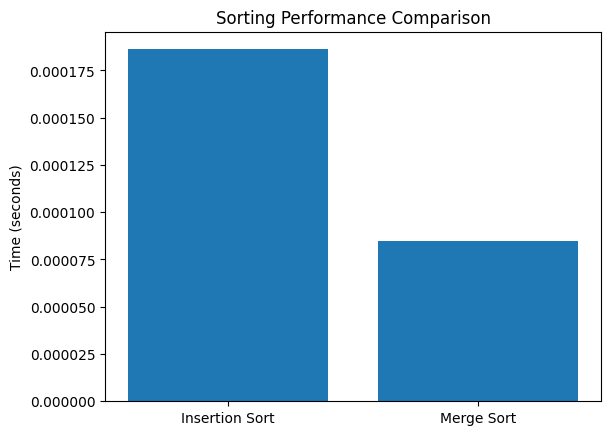


=== Travel Planner Menu ===
1. Sort by budget + logic (loop)
2. Sort by duration + logic (recursion)
3. Search trip by city name
4. Save last sorted trips to CSV
5. Compare performance of sorting algorithms
6. Exit
No trip found for that city.

=== Travel Planner Menu ===
1. Sort by budget + logic (loop)
2. Sort by duration + logic (recursion)
3. Search trip by city name
4. Save last sorted trips to CSV
5. Compare performance of sorting algorithms
6. Exit
No trip found for that city.

=== Travel Planner Menu ===
1. Sort by budget + logic (loop)
2. Sort by duration + logic (recursion)
3. Search trip by city name
4. Save last sorted trips to CSV
5. Compare performance of sorting algorithms
6. Exit

Found Trip:
Rome | $900.0 | 6 days | ruins | Logic: ¬p ∧ q

=== Travel Planner Menu ===
1. Sort by budget + logic (loop)
2. Sort by duration + logic (recursion)
3. Search trip by city name
4. Save last sorted trips to CSV
5. Compare performance of sorting algorithms
6. Exit

Found Trip:
Rome 

In [15]:

df = pd.read_csv("trips.csv") # variable assignment
df.columns = df.columns.str.strip()
trips = [Trip(row["city"], row["budget"], row["duration"], row["activity"], row["logic_expression"]) for _, row in df.iterrows()] # variable assignment
user = User(max_budget=1500, max_duration=7) # variable assignment
main_menu(trips, user)